# River Discharge Forecasting Using LSTM
This notebook demonstrates how to forecast river discharge for the next three days using an LSTM model. It involves:
1. Fetching and preprocessing river discharge data from a Django model.
2. Defining and training an LSTM model.
3. Generating forecasts and visualizing the results.


## Import Necessary Libraries
We will use the following libraries for data processing, model building, and visualization:
- `pandas` and `numpy`: For data manipulation.
- `tensorflow`: For building and training the LSTM model.
- `matplotlib`: For visualizing the results.
- `django`: To interact with the Django ORM.


In [37]:
import os
import django
import asyncio
import pandas as pd
import numpy as np
import tensorflow as tf
from asgiref.sync import sync_to_async
import nest_asyncio

nest_asyncio.apply()

## Setup Django Environment
Set up the Django environment to access the `RiverData` model and fetch river discharge data.


In [38]:
os.environ.setdefault('DJANGO_SETTINGS_MODULE', 'flood_prediction_system.settings')
django.setup()

from data_collection.models import RiverData


## Data Preprocessing
- Fetch river discharge data from the `RiverData` model.
- Convert it into a pandas DataFrame.
- Normalize the data for better model performance.


In [39]:
async def fetch_river_data():
    river_data = await sync_to_async(list)(RiverData.objects.all().values('date', 'river_discharge'))
    river_df = pd.DataFrame(river_data)
    river_df.set_index('date', inplace=True)
    river_df.index = pd.to_datetime(river_df.index)
    river_df.sort_index(inplace=True)
    river_df = river_df[~river_df.index.duplicated(keep='first')]
    return river_df

river_df = asyncio.run(fetch_river_data())

scaler = tf.keras.layers.Normalization()
scaler.adapt(np.array(river_df[['river_discharge']]))
normalized_data = scaler(np.array(river_df[['river_discharge']]))

## Define and Train LSTM Model
Define the LSTM model, prepare the data sequences, and train the model.


In [40]:
def create_sequences(data, seq_length):
    sequences, labels = [], []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i + seq_length])
        labels.append(data[i + seq_length])
    return np.array(sequences), np.array(labels)

seq_length = 7
X, y = create_sequences(normalized_data, seq_length)
X = np.reshape(X, (X.shape[0], seq_length, 1))

model = Sequential([
    LSTM(64, activation='relu', input_shape=(seq_length, 1)),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')
model.fit(X, y, epochs=20, verbose=1)


Epoch 1/20


d:\3RDYEAR PROJECTS\FINALPROJECTDJANGO\env\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.7877
Epoch 2/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4526
Epoch 3/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2454
Epoch 4/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1821
Epoch 5/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1561
Epoch 6/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1616
Epoch 7/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1650
Epoch 8/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1513
Epoch 9/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1273
Epoch 10/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1095
Epoch 11/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1179 
Epoch 12/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1082
Epoch 13/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0947
Epoch 14/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0654
Epoch 15/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0823
Epoch 16/20
15/15 ━━━━━━━━━━━

## Evaluate Model Performance
After training, we evaluate the model's accuracy on a separate test dataset using key metrics:
- Mean Squared Error (MSE)
- Mean Absolute Error (MAE)
- R-squared (optional for goodness-of-fit)


In [41]:
train_size = int(len(normalized_data) * 0.8)
train_data, test_data = normalized_data[:train_size], normalized_data[train_size:]

X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)

X_train = np.reshape(X_train, (X_train.shape[0], seq_length, 1))
X_test = np.reshape(X_test, (X_test.shape[0], seq_length, 1))


## Model Evaluation
We evaluate the model's performance on the test dataset using the metrics:
- MSE: Measures the average squared difference between actual and predicted values.
- MAE: Measures the average absolute difference.
- R-squared: Indicates how well the model explains the variance in the data.


In [42]:
loss = model.evaluate(X_test, y_test, verbose=0)
predictions_test = model.predict(X_test)

mse = np.mean((predictions_test.flatten() - y_test.flatten())**2)
mae = np.mean(np.abs(predictions_test.flatten() - y_test.flatten()))
y_test_mean = np.mean(y_test.flatten())
ss_total = np.sum((y_test.flatten() - y_test_mean) ** 2)
ss_residual = np.sum((y_test.flatten() - predictions_test.flatten()) ** 2)
r_squared = 1 - (ss_residual / ss_total)

print(f"Model Performance on Test Data:")
print(f" - MSE: {mse:.4f}")
print(f" - MAE: {mae:.4f}")
print(f" - R-squared: {r_squared:.4f}")


1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/stepWARNING:tensorflow:5 out of the last 12 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x0000023B49DEF600> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step
Model Performance on Test Data:
 - MSE: 0.2131
 - MAE: 0.2897
 - R-squared: 0.7561


## Visualize Predictions vs Actual Data
To better understand model performance, we compare the predicted values to the actual values on the test dataset.


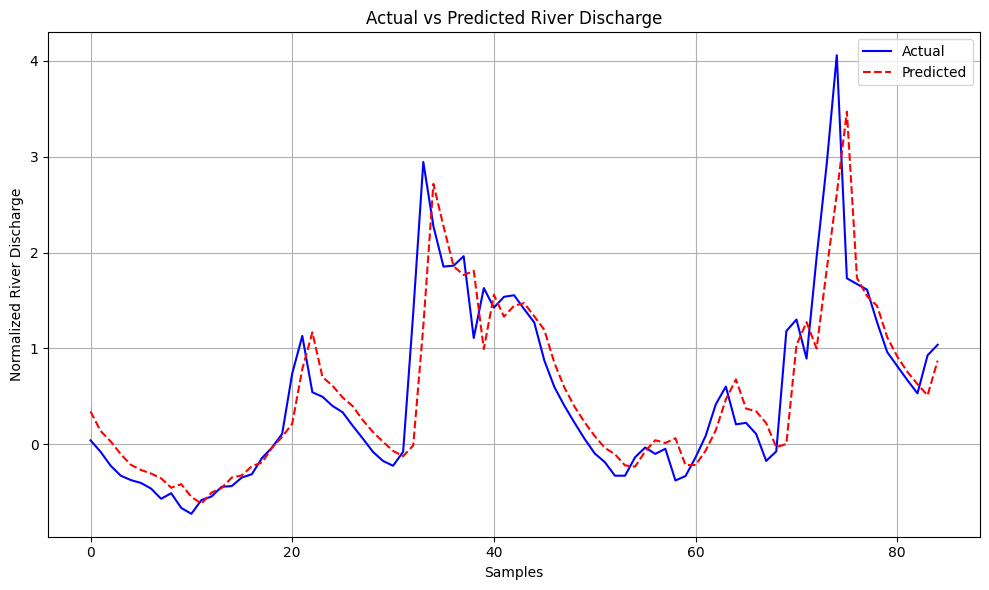

In [43]:
plt.figure(figsize=(10, 6))
plt.plot(y_test.flatten(), label="Actual", color='blue')
plt.plot(predictions_test.flatten(), label="Predicted", color='red', linestyle="dashed")
plt.xlabel("Samples")
plt.ylabel("Normalized River Discharge")
plt.title("Actual vs Predicted River Discharge")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


## Generate Forecasts
Use the trained model to predict the next three days of river discharge.


In [44]:
last_sequence = normalized_data[-seq_length:]
predictions = []

for _ in range(3):
    pred = model.predict(np.expand_dims(last_sequence, axis=0))
    predictions.append(pred[0, 0])
    last_sequence = np.append(last_sequence[1:], pred)
    last_sequence = np.reshape(last_sequence, (seq_length, 1))

predictions_unscaled = scaler.mean.numpy() + np.array(predictions) * scaler.variance.numpy() ** 0.5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


## Display Results
Print the last 10 days of historical data and the 3-day forecast.


In [45]:
last_days = river_df.tail(10)

print("Last 10 Days of River Discharge:")
for date, discharge in last_days['river_discharge'].items():
    print(f"{date.date()}: {discharge}")

forecast_dates = [last_days.index[-1] + pd.Timedelta(days=i) for i in range(1, 4)]
print("\n3-Day Forecast:")
for date, value in zip(forecast_dates, predictions_unscaled):
    print(f"{date.date()}: {value}")


Last 10 Days of River Discharge:
2024-10-27: 8.268298149108887
2024-10-28: 8.120107650756836
2024-10-29: 7.974287986755371
2024-10-30: 7.128305435180664
2024-10-31: 6.362070560455322
2024-11-01: 5.998420238494873
2024-11-02: 5.6374311447143555
2024-11-03: 5.295062065124512
2024-11-04: 6.277797698974609
2024-11-05: 6.550922870635986

3-Day Forecast:
2024-11-06: [6.4418297 6.402471  6.3775244]


## Visualize Results
Plot the historical data and the 3-day forecast.


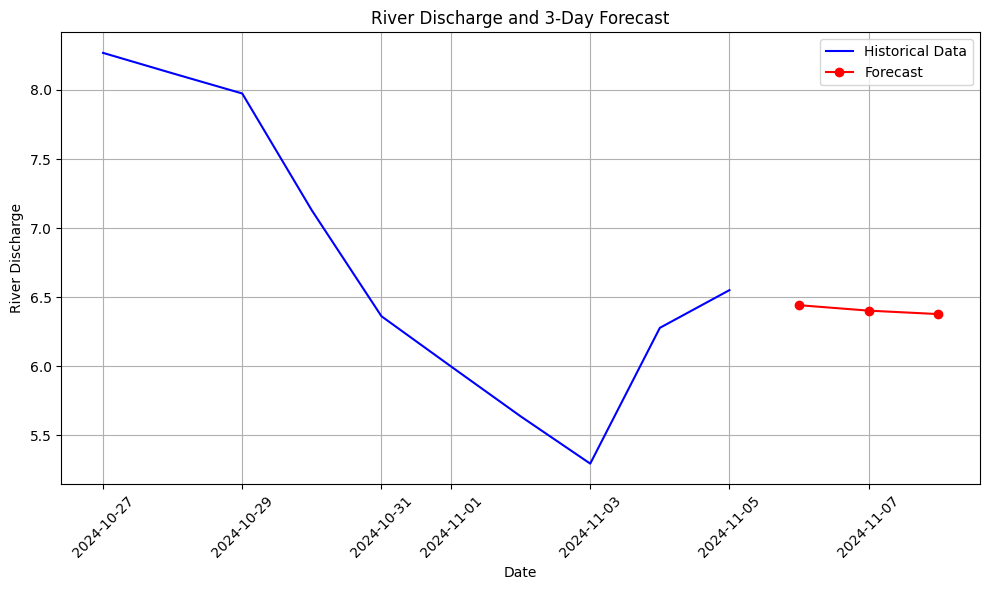

In [46]:
plt.figure(figsize=(10, 6))

plt.plot(last_days.index, last_days['river_discharge'], label="Historical Data", color='blue')

predictions_unscaled_flat = predictions_unscaled.flatten()

plt.plot(forecast_dates, predictions_unscaled_flat, label="Forecast", color='red', marker='o')

plt.xlabel("Date")
plt.ylabel("River Discharge")
plt.title("River Discharge and 3-Day Forecast")
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()
